In [1]:
import pandas as pd

dummy_df = pd.read_csv(r'dummydata.csv' )

In [2]:
dummy_df.head()

,sales_year,sales_month,Qty
0,2017,April,104441
1,2017,May,57471
2,2017,June,81634
3,2017,July,102600
4,2017,August,54978


In [3]:
dummy_df.index = dummy_df['sales_year']

In [4]:
dummy_df.head()

,sales_year,sales_month,Qty
sales_year,,,
2017,2017,April,104441
2017,2017,May,57471
2017,2017,June,81634
2017,2017,July,102600
2017,2017,August,54978


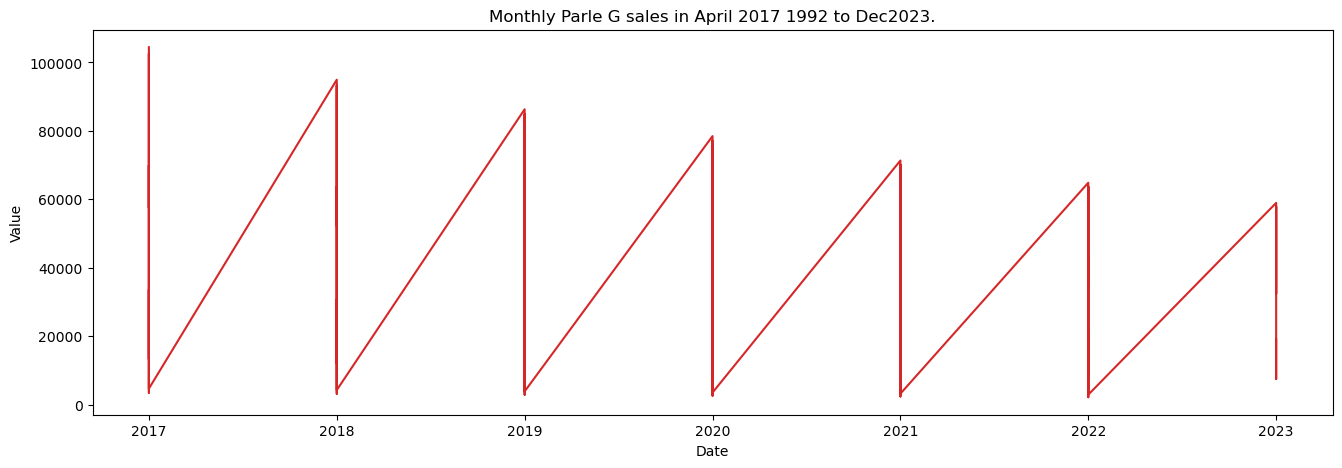

In [6]:
##Draw Plot
import matplotlib.pyplot as plt
import matplotlib as mpl
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(dummy_df, x=dummy_df.index, y=dummy_df.Qty, title='Monthly Parle G sales in April 2017 1992 to Dec2023.')    

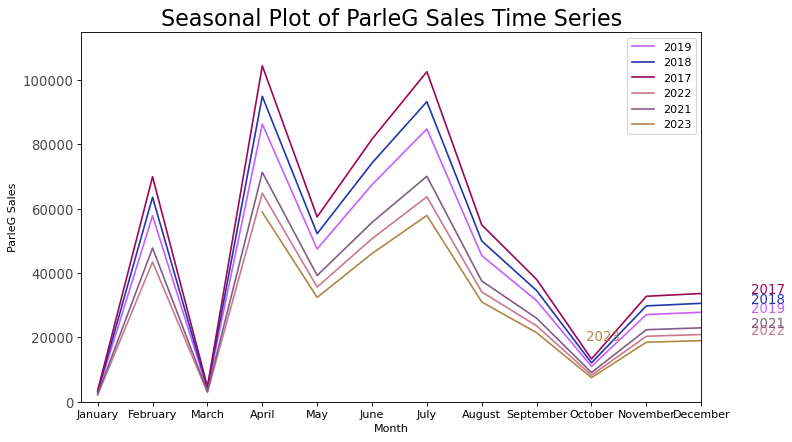

In [8]:
import numpy as np

dummy_df.rename(columns={'sales_year':'year'},inplace = True)

# Aggregate data by month
monthly_data = dummy_df.groupby(['year', 'sales_month']).sum().reset_index()

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Convert 'sales_month' to categorical with specified order
monthly_data['sales_month'] = pd.Categorical(monthly_data['sales_month'], categories=month_order, ordered=True)

# Sort the DataFrame by 'sales_month' to ensure correct plotting order
monthly_data.sort_values('sales_month', inplace=True)

# Prep Colors
np.random.seed(100)
years = monthly_data['year'].unique()
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Draw Plot
plt.figure(figsize=(10, 6), dpi=80)

for i, y in enumerate(years):
    if i > 0:
        data = monthly_data.loc[monthly_data.year==y, :]
        plt.plot('sales_month', 'Qty', data=data, color=mycolors[i], label=y)
        plt.text(data.shape[0]-0.1, data['Qty'].iloc[-1], y, fontsize=12, color=mycolors[i])

# Decoration
plt.gca().set(xlim=(-0.3, 11), ylim=(0, monthly_data['Qty'].max()*1.1),
              ylabel='ParleG Sales', xlabel='Month')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of ParleG Sales Time Series", fontsize=20)
plt.legend(loc='upper right')
plt.show()


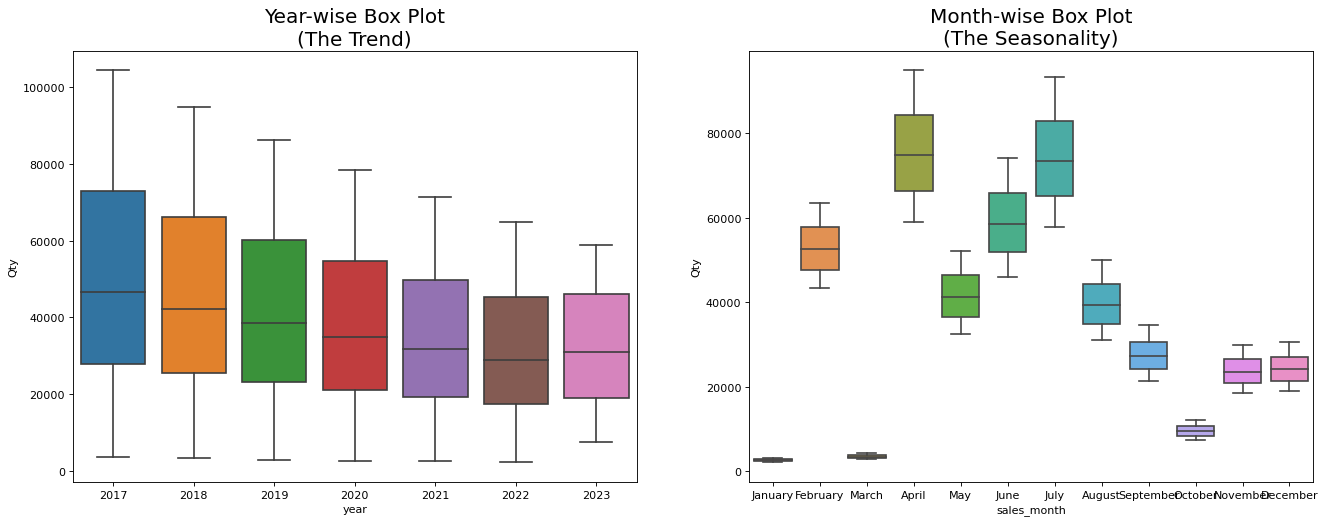

In [10]:
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='Qty', data=monthly_data, ax=axes[0])
sns.boxplot(x='sales_month', y='Qty', data=monthly_data.loc[~monthly_data.year.isin([2017]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

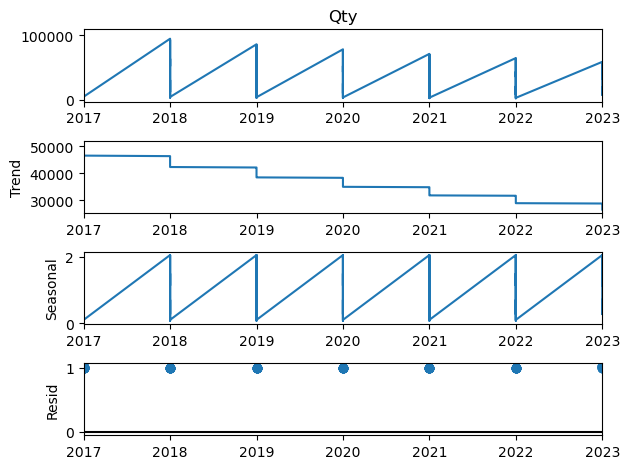

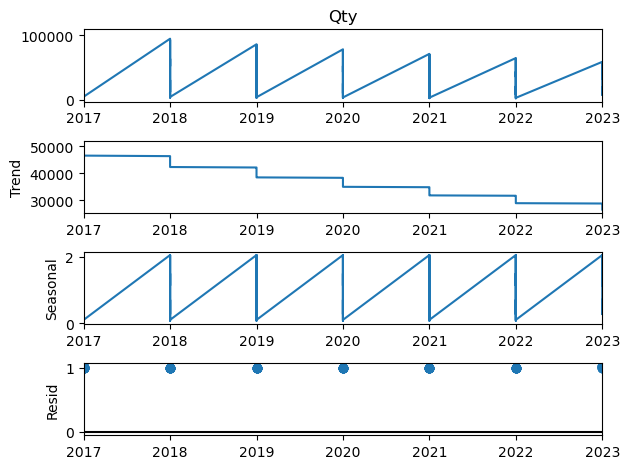

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_mul = seasonal_decompose(dummy_df['Qty'], model='multiplicative',period = 12, extrapolate_trend='freq')
result_mul.plot()


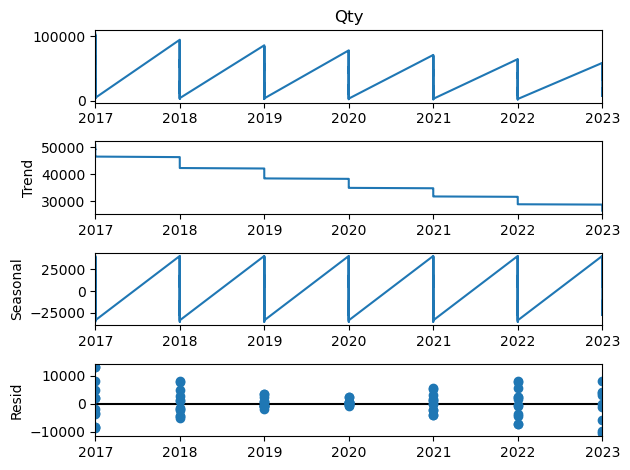

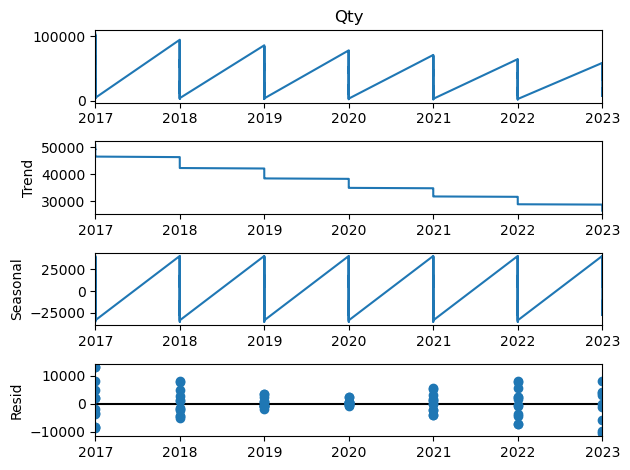

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_add = seasonal_decompose(dummy_df['Qty'], model='additive',period = 12, extrapolate_trend='freq')
result_add.plot()

In [18]:
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
sales_year,,,,
2017,2.044039,50937.349019,1.003103,104441.0
2017,1.129535,50583.494998,1.005867,57471.0
2017,1.613585,50229.640977,1.007208,81634.0
2017,2.040531,49875.786956,1.008125,102600.0
2017,1.100897,49521.932935,1.008427,54978.0


In [19]:
df_reconstructed_add = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_reconstructed_add.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head()

,seas,trend,resid,actual_values
sales_year,,,,
2017,2.044039,50937.349019,1.003103,104441.0
2017,1.129535,50583.494998,1.005867,57471.0
2017,1.613585,50229.640977,1.007208,81634.0
2017,2.040531,49875.786956,1.008125,102600.0
2017,1.100897,49521.932935,1.008427,54978.0


In [29]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(monthly_data.Qty.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.5875245187197502
p-value: 0.4898572833293896
Critial Values:
   1%, -3.530398990560757
Critial Values:
   5%, -2.9050874099328317
Critial Values:
   10%, -2.5900010121107266


Text(0.5, 1.0, 'ParleG Sales detrended by subtracting the least squares fit')

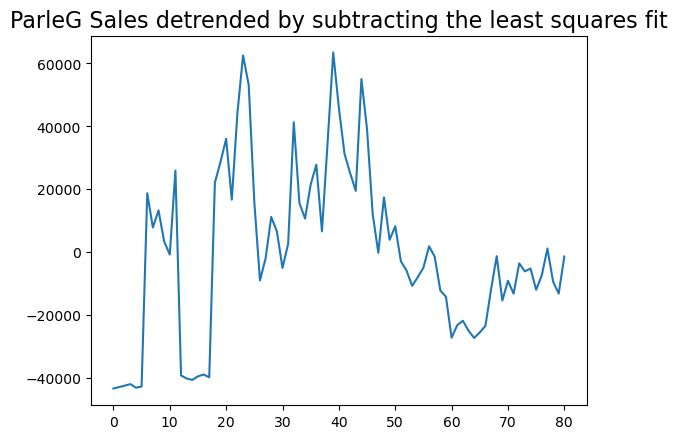

In [23]:
# Using scipy: Subtract the line of best fit
from scipy import signal
detrended = signal.detrend(monthly_data.Qty.values)
plt.plot(detrended)
plt.title('ParleG Sales detrended by subtracting the least squares fit', fontsize=16)

In [30]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test on detrended data
result_detrended = adfuller(detrended, autolag='AIC')

# Extract ADF test results
adf_statistic_detrended = result_detrended[0]
p_value_detrended = result_detrended[1]
critical_values_detrended = result_detrended[4]

# Print ADF test results
print(f'ADF Statistic (Detrended): {adf_statistic_detrended}')
print(f'p-value (Detrended): {p_value_detrended}')
print('Critical Values (Detrended):')
for key, value in critical_values_detrended.items():
    print(f'   {key}: {value}')


ADF Statistic (Detrended): -1.9505950766277653
p-value (Detrended): 0.3086463621696116
Critical Values (Detrended):
   1%: -3.530398990560757
   5%: -2.9050874099328317
   10%: -2.5900010121107266


<function matplotlib.pyplot.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)>

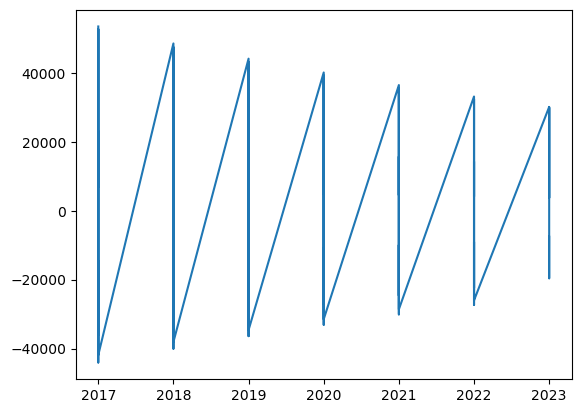

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_mul = seasonal_decompose(dummy_df['Qty'], model='multiplicative',period = 12, extrapolate_trend='freq')
detrended_2 = dummy_df.Qty.values - result_mul.trend
plt.plot(detrended_2)
plt.title

In [39]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test on detrended data
result_detrended = adfuller(detrended_2, autolag='AIC')

# Extract ADF test results
adf_statistic_detrended = result_detrended[0]
p_value_detrended = result_detrended[1]
critical_values_detrended = result_detrended[4]

# Print ADF test results
print(f'ADF Statistic (Detrended): {adf_statistic_detrended}')
print(f'p-value (Detrended): {p_value_detrended}')
print('Critical Values (Detrended):')
for key, value in critical_values_detrended.items():
    print(f'   {key}: {value}')

ADF Statistic (Detrended): -1.6944586118701719
p-value (Detrended): 0.4339698046389553
Critical Values (Detrended):
   1%: -3.530398990560757
   5%: -2.9050874099328317
   10%: -2.5900010121107266


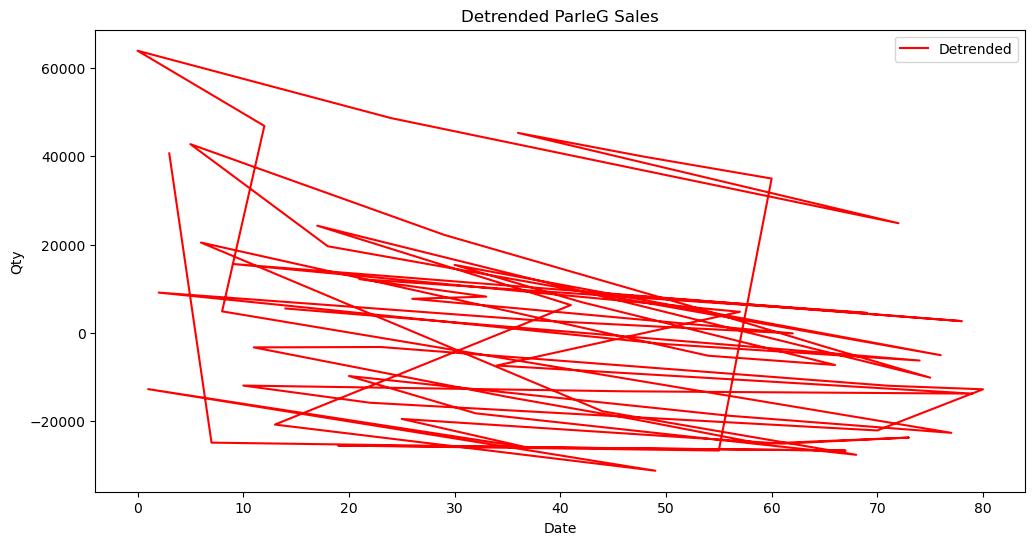

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming monthly_data is already loaded and preprocessed

# Calculate the rolling mean with a suitable window size
window_size = 12  # You can adjust this value based on the seasonality of your data
rolling_mean = monthly_data['Qty'].rolling(window=window_size).mean()

# Subtract the rolling mean from the original data to obtain the detrended series
detrended_3 = monthly_data['Qty'] - rolling_mean

# Plot the original data and the detrended data
plt.figure(figsize=(12, 6))
#plt.plot(monthly_data.index, monthly_data['Qty'], label='Original')
plt.plot(monthly_data.index, detrended, label='Detrended', color='red')
plt.title('Detrended ParleG Sales')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.legend()
plt.show()


In [43]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
result = adfuller(detrended_3.dropna())  # Drop NA values resulting from rolling mean
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')


ADF Statistic: -3.366324110039198
p-value: 0.012161871678813803
Critical Values:
   1%: -3.5386953618719676
   5%: -2.9086446751210775
   10%: -2.591896782564878


[]

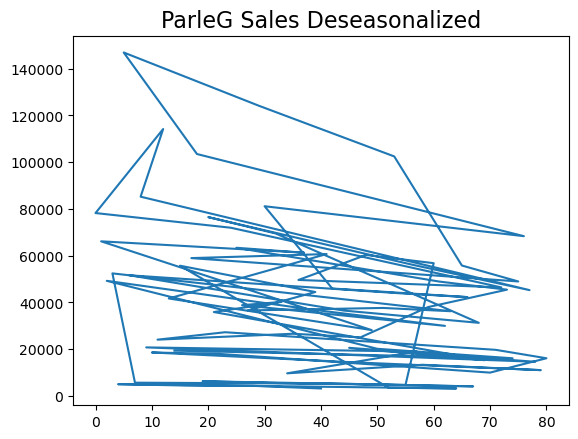

In [46]:
# Time Series Decomposition
result_mul = seasonal_decompose(monthly_data['Qty'], model='multiplicative', extrapolate_trend='freq',period=12)

# Deseasonalize
deseasonalized = monthly_data.Qty.values / result_mul.seasonal

# Plot
plt.plot(deseasonalized)
plt.title('ParleG Sales Deseasonalized', fontsize=16)
plt.plot()

In [47]:
deseasonalized.head()

40    3138.206852
28    4256.705669
16    4402.938123
4     4974.926177
64    3155.265280
Name: seasonal, dtype: float64

In [54]:
deseasonalized.info()

<class 'pandas.core.series.Series'>
Index: 81 entries, 40 to 14
Series name: seasonal
Non-Null Count  Dtype  
--------------  -----  
81 non-null     float64
dtypes: float64(1)
memory usage: 1.3 KB


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

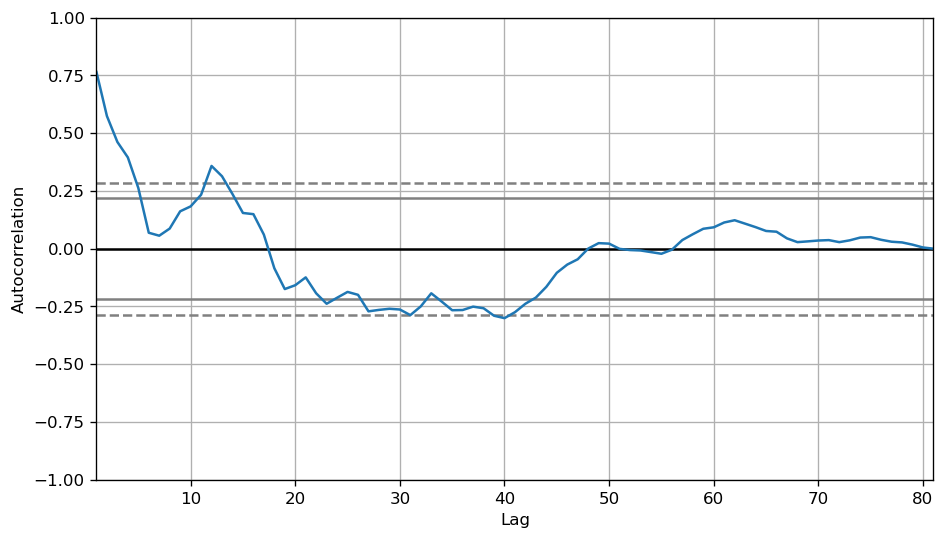

In [50]:
from pandas.plotting import autocorrelation_plot

# Draw Plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(monthly_data.Qty.tolist())


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


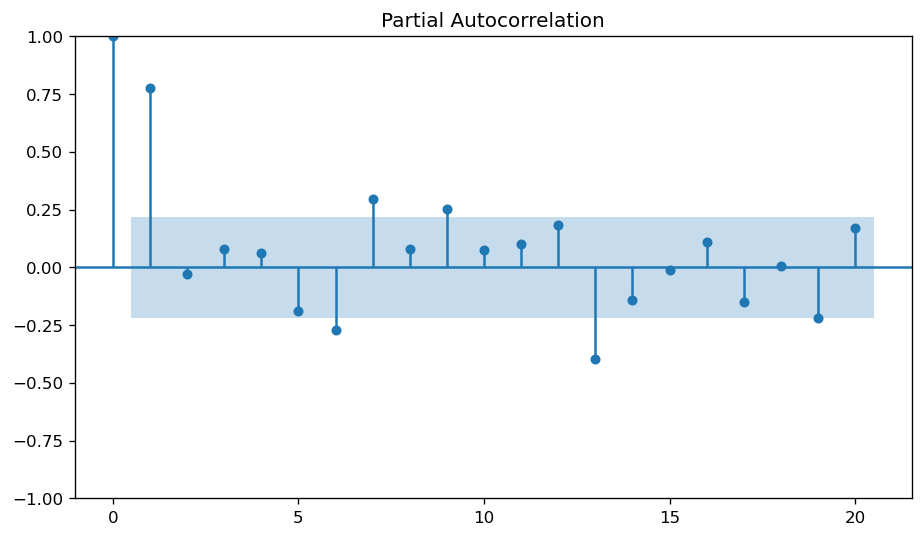

In [51]:
from statsmodels.graphics.tsaplots import plot_pacf

# Draw Plot
plot_pacf(monthly_data.Qty)
plt.show()



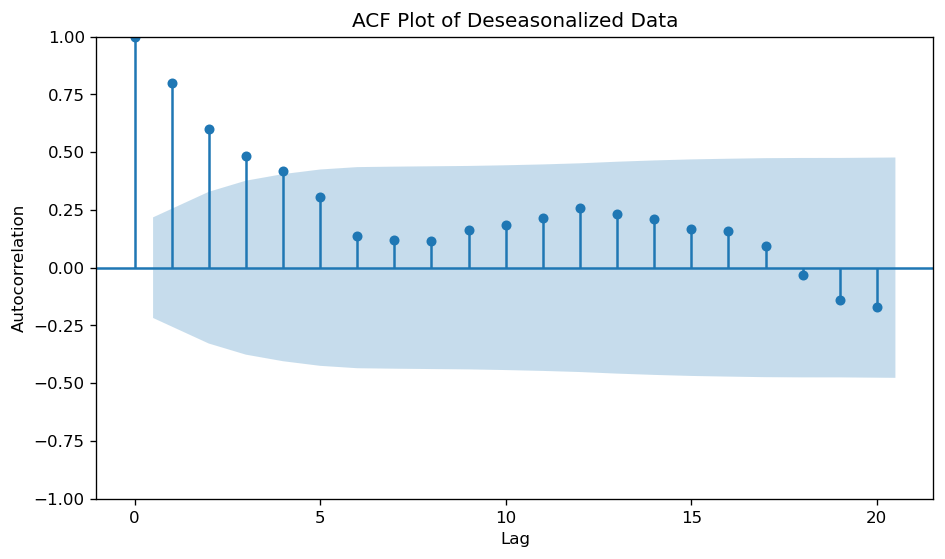

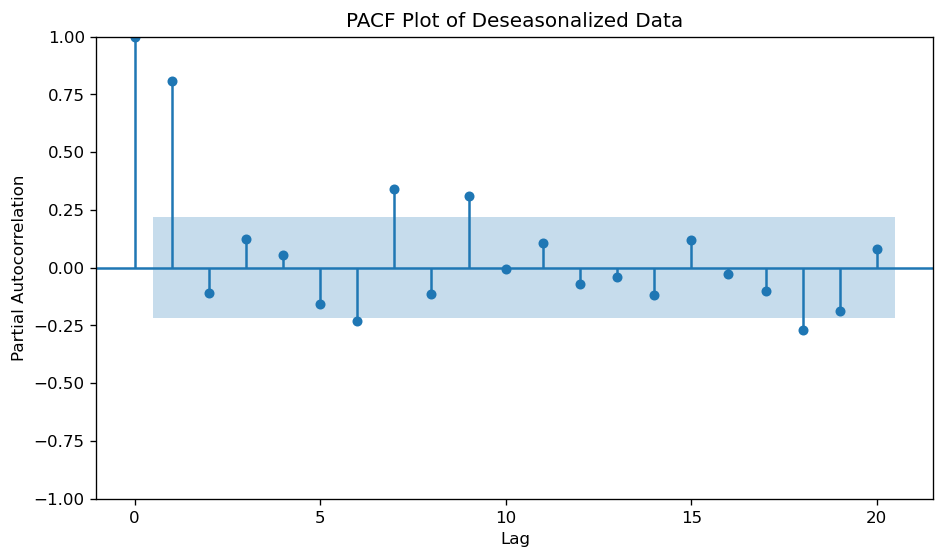

In [52]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
plot_acf(deseasonalized, lags=20)
plt.title('ACF Plot of Deseasonalized Data')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

# Plot PACF
plot_pacf(deseasonalized, lags=20)
plt.title('PACF Plot of Deseasonalized Data')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()


In [60]:
print(len(deseasonalized))

81


In [57]:
import pandas as pd

# Assuming monthly_data is your DataFrame containing monthly data

# Get the unique years and months from the data
years = monthly_data['year'].unique()
months = monthly_data['sales_month'].unique()

# Create an empty list to store the date ranges
date_ranges = []

# Loop through each year and month to generate date ranges
for year in years:
    for month in months:
        # Construct the first and last day of the month using pd.Period
        period = pd.Period(f'{year}-{month}')
        first_day = period.start_time
        last_day = period.end_time
        
        # Append the date range to the list
        date_ranges.append((first_day, last_day))

# Now you have a list of date ranges corresponding to each month in your data
# You can use these date ranges to filter your data or for other purposes


81


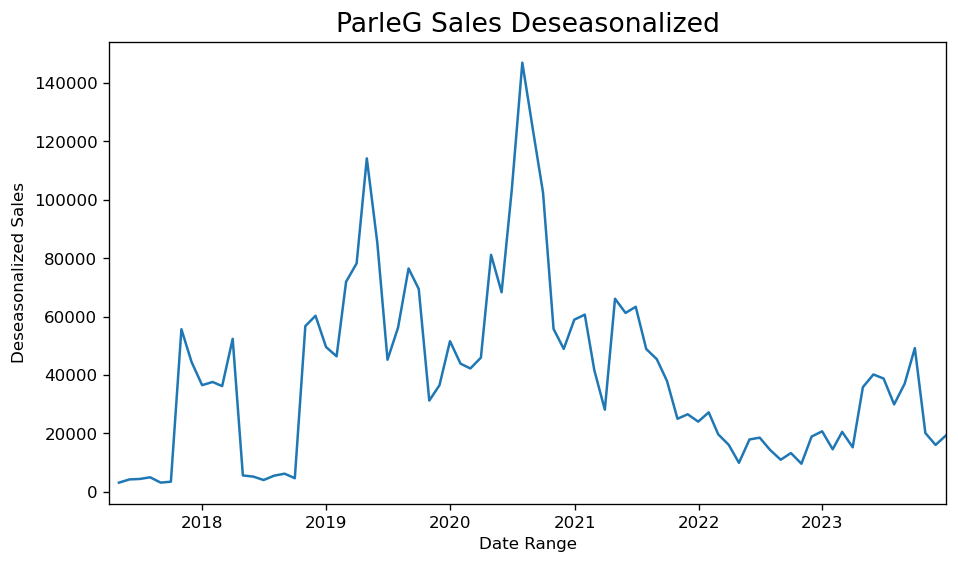

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

print(len(deseasonalized))

# Assuming deseasonalized is your deseasonalized series

# Get the number of months in the data
num_months = len(deseasonalized)

# Generate date ranges based on the number of months
date_ranges = pd.date_range(start='2017-04-01', periods=num_months, freq='M')

# Create a DataFrame with the deseasonalized series and the date ranges
deseasonalized_df = pd.DataFrame({'date_range': date_ranges, 'deseasonalized_sales': deseasonalized})

# Sort the DataFrame by the 'date_range' column
deseasonalized_df.sort_values('date_range', inplace=True)

# Print the first few rows of the sorted DataFrame
#print(deseasonalized_df.head())



# Plot the deseasonalized series
plt.plot(deseasonalized_df['date_range'], deseasonalized_df['deseasonalized_sales'])
plt.title('ParleG Sales Deseasonalized', fontsize=16)
plt.xlim('2017-04-01', '2023-12-31')

plt.xlabel('Date Range')
plt.ylabel('Deseasonalized Sales')
plt.show()


In [72]:
deseasonalized_df.head()

,date_range,deseasonalized_sales
40,2017-04-30,3138.206852
28,2017-05-31,4256.705669
16,2017-06-30,4402.938123
4,2017-07-31,4974.926177
64,2017-08-31,3155.265280


In [71]:
from statsmodels.tsa.arima.model import ARIMA
# Train the ARIMA model
def train_arima_model(data):
    # Define parameters for ARIMA model (p, d, q)
    p, d, q = 1, 0,1
    # Fit ARIMA model to data
    model = ARIMA(data, order=(p, d, q))
    fitted_model = model.fit()
    return fitted_model

In [95]:
from statsmodels.tsa.arima.model import ARIMA

# Define the ARIMA model
# You need to specify the order (p, d, q) based on your analysis
p, d, q = 1, 0, 1  # Example values, adjust based on your analysis
model = ARIMA(deseasonalized_df.deseasonalized_sales, order=(p, d, q))

# Fit the ARIMA model
model_fit = model.fit()

# Make forecasts
forecast_steps = 12  # Number of steps to forecast into the future
forecast = model_fit.forecast(steps=forecast_steps)

print(forecast)

# # Plot the forecasts
# plt.plot(deseasonalized, label='Deseasonalized Data')
# plt.plot(range(len(deseasonalized), len(deseasonalized) + forecast_steps), forecast, label='Forecast')
# plt.title('ARIMA Forecasting')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.legend()
# plt.show()


81    24136.998832
82    28049.449077
83    30991.407528
84    33203.606784
85    34867.065202
86    36117.899140
87    37058.460999
88    37765.714443
89    38297.532131
90    38697.431284
91    38998.134583
92    39224.247774
Name: predicted_mean, dtype: float64


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [75]:
def forecast_quantity(start_date, end_date, forecast_horizon):
    # Filter historical sales data for the selected item and date range
    item_sales_data = deseasonalized_df[(deseasonalized_df['date_range'] >= start_date) & 
                            (deseasonalized_df['date_range']  <= end_date)]
    # Train the ARIMA model using filtered sales data
    item_model = train_arima_model(item_sales_data['deseasonalized_sales'])
    # Forecast using the trained model
    forecast = item_model.forecast(steps=forecast_horizon)   
    
    return forecast

In [88]:
def forecast_endpoint():
#     item_id = request.json['item_id']
#     start_date = request.json['start_date']
#     end_date = request.json['end_date']
#     forecast_horizon = request.json['forecast_horizon']
    start_date = '2023-01-01'
    end_date = '2023-12-31'
    forecast_horizon = 1
    
    # Call forecast_quantity function with user inputs
    forecast = forecast_quantity(start_date, end_date, forecast_horizon)
    
    
    # Return forecasted quantity to frontend
    #return jsonify({'forecast': forecast})
    
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    actual_values = 1959
    #forecast = forecast.flatten()  # Reshape forecast to 1D array if necessary
#     mae = mean_absolute_error(actual_values, forecast)
#     mse = mean_squared_error(actual_values, forecast)
#     rmse = np.sqrt(mse) 

    print(forecast)
#     print("mae-----",mae)
#     print("mse--------",mse)
#     print("rmse--------",rmse)

   


In [89]:
forecast_endpoint()

12    25036.901953
dtype: float64


C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
